# Analysis of Covid-19 positive rate variations among different postcode areas in NYC

##  Introduction
Positive Covid rates vary greatly among different areas in New York City. By using demographic data together with Foursquare venue location data, we may get some clues to explain the variations.

This analysis is not designed for any commercial purpose, but to show public/government the possible explanations behind the pandemic.

## Data Acquisition
In this section, I will explain all types of data I would consider in this study, and the resources to get them. Since I want to compare the posiivie rate variations in different areas, the data I need will be exhibited by small areas, like community neighborhood or zip code area. I choose to use zip code area data for this study.


#### Covid data
NYC Covid-19 data is essential as the final target to understand. Covid data can be accessed through the website of NYC Department of Health and Mental Hygiene. The department has a github account to update the data daily: https://github.com/nychealth/coronavirus-data. The data show covid positive rates in each postal code area.

#### Demographic data
Population density could possibly cause different virus spreading rates. Also, since different age groups have their different social activity habits and show quite different reaction to the pandemic, it's interesting to know if the age percentage has played a role to cause different covid positive rates. The information can be found on data.census.gov and was collected from American Community Survey 2018.

#### Geographic data
`uszipcode` is a python zipcode database. Information like the area of the post code areas, latitude and longitude can be easily loaded from the library. The library also offers economic information like median household income, which can also be used in our analysis.

#### Venue location data
For the venue data, first, I am curious to know if more restaurants in an area is related to a higher covid rate.

Second, different types and different quantities of venues can be potential reasons to cause higher or lower rates. With the venue information from Foursquare, we can cluster the venues based on zip code, and see if the cluster is related to different covid rates.

## Analysis

In this part, let's perform some basic explanatory data analysis and derive some additional info from our raw data. First let's import all the datasets:

#### Import all the libraries:

In [7]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

from uszipcode import SearchEngine #get basic demographic info for each postal area.
search = SearchEngine(simple_zipcode=True)

#### Import Covid data:

In [2]:
covid_data = pd.read_csv('data-by-modzcta.csv')
covid_data.head()

,MODIFIED_ZCTA,NEIGHBORHOOD_NAME,BOROUGH_GROUP,COVID_CASE_COUNT,COVID_CASE_RATE,POP_DENOMINATOR,COVID_DEATH_COUNT,COVID_DEATH_RATE,PERCENT_POSITIVE,TOTAL_COVID_TESTS
0,10001,Chelsea/NoMad/West Chelsea,Manhattan,433,1837.62,23563.03,26,110.34,6.04,7165
1,10002,Chinatown/Lower East Side,Manhattan,1305,1700.21,76755.41,161,209.76,8.64,15105
2,10003,East Village/Gramercy/Greenwich Village,Manhattan,525,975.81,53801.62,34,63.20,4.47,11750
3,10004,Financial District,Manhattan,39,1068.32,3650.61,1,27.39,4.83,807
4,10005,Financial District,Manhattan,91,1083.84,8396.11,2,23.82,4.75,1915


Clean up the data by removing unnecessary columns and changing column names:

In [3]:
covid_df = covid_data[['MODIFIED_ZCTA','PERCENT_POSITIVE']]
covid_df.rename(columns={'MODIFIED_ZCTA':'ZipCode','PERCENT_POSITIVE':'CovidPercentagePositive'},inplace=True )
covid_df.head()

C:\Users\Domomo\anaconda3\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,ZipCode,CovidPercentagePositive
0,10001,6.04
1,10002,8.64
2,10003,4.47
3,10004,4.83
4,10005,4.75


We can see the distribution on the map:

In [4]:
nyc_df = covid_df[['ZipCode','CovidPercentagePositive']]

#chnage zipcode to str to match the format from json file:
nyc_str = nyc_df[['ZipCode', 'CovidPercentagePositive']]
nyc_str['ZipCode'] =nyc_str['ZipCode'].astype(str)


#import json file
with open('nyc_zip.txt') as json_file: #json file with zip code area information
    nyc_zipmap = json.load(json_file)

# create a plain map centered on NYC
nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=11, tiles='Stamen Toner')

# generate choropleth map using the total immigration of each country to Canada from 1980 to 2013
nyc_map.choropleth(
    geo_data= nyc_zipmap,
    data=nyc_str,
    columns=['ZipCode', 'CovidPercentagePositive'],
    key_on='feature.properties.postalCode', #always starts with feature instead of features
    fill_color='YlOrRd', 
    fill_opacity=0.9, 
    line_opacity=0.2,
    legend_name='Covid Positive Rates'
)
nyc_map.save('nyc_covid_map.html')
# display map
nyc_map

a snapshot of the map to visualize on github:

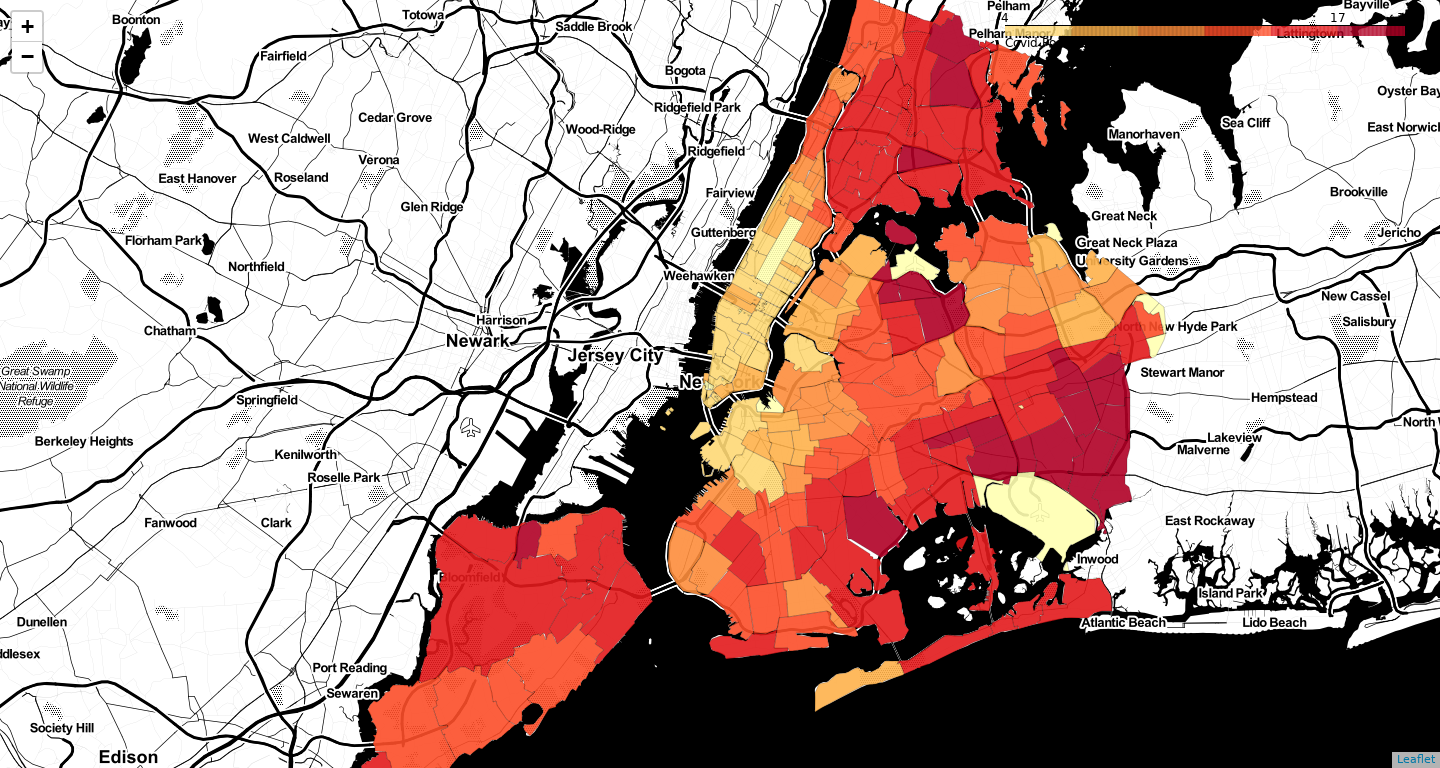



We can see the great differences of Covid positive rates for different postal code areas.
Then, we import some demographic, geographic and economic information from `uszipcode` database:

In [5]:
nyc_df = covid_df[['ZipCode','CovidPercentagePositive']]
pd = []
rm = []
ic = []
lat = []
lng = []
for index, row in nyc_df.iterrows():
    zipcode  = row['ZipCode'] 
    
    demoinfo = search.by_zipcode(str(int(zipcode)))
    
   
    pd = pd + [demoinfo.population_density]
    rm = rm + [np.sqrt(demoinfo.land_area_in_sqmi)/2*1609] #estimate radius and change the unit to meters
    ic = ic + [demoinfo.median_household_income]
    lat = lat + [demoinfo.lat]
    lng = lng + [demoinfo.lng]
    
nyc_df.insert(1, "Latitude", lat, True)
nyc_df.insert(2, "Longitude", lng, True)
nyc_df.insert(3, "Radius", rm, True)
nyc_df.insert(4, "PopulationDensity", pd, True)
nyc_df.insert(5, "Income", ic, True)


nyc_df.head()

,ZipCode,Latitude,Longitude,Radius,PopulationDensity,Income,CovidPercentagePositive
0,10001,40.750,-73.990,633.463933,33959.0,81671,6.04
1,10002,40.720,-73.990,754.687896,92573.0,33218,8.64
2,10003,40.730,-73.990,612.688946,97188.0,92540,4.47
3,10004,40.700,-74.020,602.032674,5519.0,129313,4.83
4,10005,40.705,-74.005,212.850693,97048.0,124670,4.75


As for the age percentage information for each zip code area, we have to import from Aumerican Community Survey on data.census.gov :

In [8]:
age_df = pd.read_csv('age_dataframe.csv')
age_df.head()

,ZipCode,YouthRatio,SeniorRatio
0,10001,8.7,14.8
1,10002,13.3,21.1
2,10003,7.1,11.8
3,10004,11.4,7.5
4,10005,12.5,1.3


Youth is defined as people younger than 18 years old, and senior people are older than 65.


Let's combine the data to nyc_df dataframe:

In [9]:
nyc_df.insert(6, "PercentageYouth", age_df['YouthRatio'], True) #zipcode index is the same for nyc_df and age_df
nyc_df.insert(7, "PercentageSenior", age_df['SeniorRatio'], True)
nyc_df.head()

,ZipCode,Latitude,Longitude,Radius,PopulationDensity,Income,PercentageYouth,PercentageSenior,CovidPercentagePositive
0,10001,40.750,-73.990,633.463933,33959.0,81671,8.7,14.8,6.04
1,10002,40.720,-73.990,754.687896,92573.0,33218,13.3,21.1,8.64
2,10003,40.730,-73.990,612.688946,97188.0,92540,7.1,11.8,4.47
3,10004,40.700,-74.020,602.032674,5519.0,129313,11.4,7.5,4.83
4,10005,40.705,-74.005,212.850693,97048.0,124670,12.5,1.3,4.75


To import the restaurant information, we will need to use Foursquare:

In [10]:
CLIENT_ID = 'ORFGR1PWESGLTSQAX22WEFLKIWR5VZ4IF3TXIRKCM3NBUEBI' # Foursquare ID
CLIENT_SECRET = 'VMUZ0TBHVZ5OBGV5FFYBMDPNC1PLBPG5NKODGA0AVLLKJM0J' #  Foursquare Secret
VERSION = '20200801' # Foursquare API version

LIMIT = 100
food=[]
for index, row in nyc_df.iterrows():
    latitude = row['Latitude'] 
    longitude = row['Longitude']
    radius = row['Radius']
    
    url = 'https://api.foursquare.com/v2/venues/explore?categoryId=4d4b7105d754a06374d81259&client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
    results = requests.get(url).json()
   
    food = food + [results['response']['totalResults']/np.square(radius/1609*2)]

nyc_df.insert(8, "RestaurantDensity", food, True)

nyc_df.head()

,ZipCode,Latitude,Longitude,Radius,PopulationDensity,Income,PercentageYouth,PercentageSenior,RestaurantDensity,CovidPercentagePositive
0,10001,40.750,-73.990,633.463933,33959.0,81671,8.7,14.8,269.354839,6.04
1,10002,40.720,-73.990,754.687896,92573.0,33218,13.3,21.1,282.954545,8.64
2,10003,40.730,-73.990,612.688946,97188.0,92540,7.1,11.8,337.931034,4.47
3,10004,40.700,-74.020,602.032674,5519.0,129313,11.4,7.5,19.642857,4.83
4,10005,40.705,-74.005,212.850693,97048.0,124670,12.5,1.3,185.714286,4.75


In [11]:
cor_matrix =nyc_df[['CovidPercentagePositive','Radius',"PopulationDensity",'Income','PercentageYouth','PercentageSenior','RestaurantDensity']].corr()

In [18]:
cor_matrix

,CovidPercentagePositive,Radius,PopulationDensity,Income,PercentageYouth,PercentageSenior,RestaurantDensity
CovidPercentagePositive,1.000000,0.470658,-0.437801,-0.528183,0.601788,0.001430,-0.664865
Radius,0.470658,1.000000,-0.604117,-0.261077,0.337497,0.198124,-0.579475
PopulationDensity,-0.437801,-0.604117,1.000000,0.042710,-0.266394,-0.076080,0.613734
Income,-0.528183,-0.261077,0.042710,1.000000,-0.405369,0.040974,0.444365
PercentageYouth,0.601788,0.337497,-0.266394,-0.405369,1.000000,-0.314499,-0.537918
PercentageSenior,0.001430,0.198124,-0.076080,0.040974,-0.314499,1.000000,-0.036766
RestaurantDensity,-0.664865,-0.579475,0.613734,0.444365,-0.537918,-0.036766,1.000000


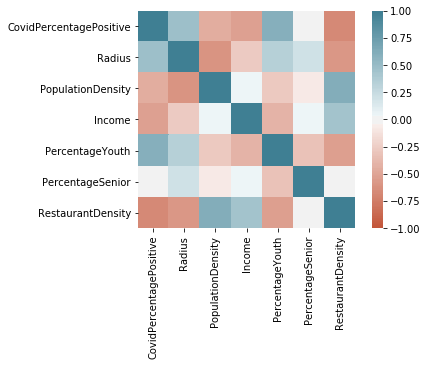

In [22]:
import seaborn as sns
ax = sns.heatmap(
    cor_matrix,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

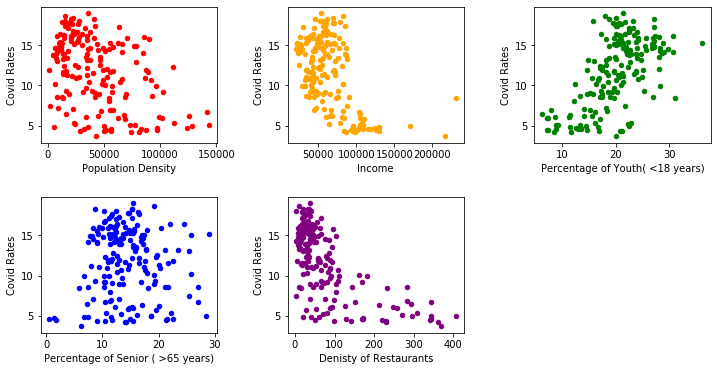

In [98]:
fig = plt.figure() # create figure
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax0 = fig.add_subplot(2, 3, 1) # add subplot 1 (1 row, 2 columns, first plot)
ax1 = fig.add_subplot(2, 3, 2) # add subplot 2 (1 row, 2 columns, second plot). 
ax2 = fig.add_subplot(2, 3, 3) 
ax3 = fig.add_subplot(2, 3, 4)
ax4 = fig.add_subplot(2, 3, 5)

# Subplot 1: 
nyc_df.plot(kind='scatter', x='PopulationDensity', y='CovidPercentagePositive', figsize=(12, 6), color='red',ax=ax0) # add to subplot 1
ax0.set_xlabel('Population Density')
ax0.set_ylabel('Covid Rates')

# Subplot 2: 
nyc_df.plot(kind='scatter', x='Income', y='CovidPercentagePositive',figsize=(12, 6), color='orange', ax=ax1) # add to subplot 2
ax1.set_xlabel('Income')
ax1.set_ylabel('Covid Rates')

# Subplot 3: 
nyc_df.plot(kind='scatter', x='PercentageYouth', y='CovidPercentagePositive',figsize=(12, 6), color='green', ax=ax2) # add to subplot 3
ax2.set_xlabel('Percentage of Youth( <18 years)')
ax2.set_ylabel('Covid Rates')

# Subplot 4: 
nyc_df.plot(kind='scatter', x='PercentageSenior', y='CovidPercentagePositive',figsize=(12, 6), color='blue', ax=ax3) # add to subplot 4
ax3.set_xlabel('Percentage of Senior ( >65 years)')
ax3.set_ylabel('Covid Rates')

# Subplot 5: 
nyc_df.plot(kind='scatter', x='RestaurantDensity', y='CovidPercentagePositive',figsize=(12, 6), color='purple', ax=ax4) # add to subplot 4
ax4.set_xlabel('Denisty of Restaurants')
ax4.set_ylabel('Covid Rates')

plt.show()

We all know that **senior people** are more vulnerable when facing covid-19 virus, however, the percentage of older people in the area has no direct correlation to covid rates. **population density** also show no direct relationship with covid rates.

Higher **median household income** areas show much lower covid rates compare with low income areas. Covid Rates were found higher in areas with higher **Youth percentage**.

Surprisingly, **restaurants density** appears to be negatively correlated to covid rates. This implies a possible relationship between venues distribution and covid rates. Thus, we decide to dig deeper to explain the phenomenon.


For venue data, we adopted Foursquare to collect the information:

In [32]:
def getNearbyVenues(zipcode, latitudes, longitudes, radius):
    
    venues_list=[]
    for zipcode,lat, lng, radius in zip(zipcode, latitudes, longitudes,radius):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            zipcode, 
            v['venue']['name'], 
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['ZipCode', 
                  'Venue',  
                  'Venue Category']
    
    return(nearby_venues)

In [33]:
nyc_venues = getNearbyVenues(zipcode=nyc_df['ZipCode'], latitudes=nyc_df['Latitude'], longitudes=nyc_df['Longitude'],radius = nyc_df['Radius'])
print(nyc_venues.shape)                                  
nyc_venues.head()

(12531, 3)


,ZipCode,Venue,Venue Category
0,10001,STORY,Gift Shop
1,10001,Louis Vuitton,Boutique
2,10001,Delta Sky360° Club,Lounge
3,10001,Victoria's Secret,Lingerie Store
4,10001,Gucci,Leather Goods Store


In [34]:
# one hot encoding
nyc_onehot = pd.get_dummies(nyc_venues[['Venue Category']], prefix="", prefix_sep="")

# add zipcode column back to dataframe
nyc_onehot['ZipCode'] = nyc_venues['ZipCode'] 

# move ZipCode column to the first column
fixed_columns = [nyc_onehot.columns[-1]] + list(nyc_onehot.columns[:-1])
nyc_onehot = nyc_onehot[fixed_columns]

nyc_onehot.head(2)

,ZipCode,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,Airport Tram,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Carpet Store,Casino,Caucasian Restaurant,Cemetery,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Basketball Court,College Cafeteria,College Rec Center,College Residence Hall,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Currency Exchange,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Emergency Room,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Fishing Store,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,National Park,Neighborhood,New American Restaurant,Newsstand,Ni

Group in zipcode area and count the average number:

In [35]:
nyc_zip_grouped = nyc_onehot.groupby('ZipCode').mean().reset_index()
nyc_zip_grouped.head(3)

,ZipCode,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,Airport Tram,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Carpet Store,Casino,Caucasian Restaurant,Cemetery,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Basketball Court,College Cafeteria,College Rec Center,College Residence Hall,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Currency Exchange,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Emergency Room,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Fishing Store,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,National Park,Neighborhood,New American Restaurant,Newsstand,Ni

Use k-means clustering method to cluster the venues:

In [57]:
#Remove the zipcode column to get the matrix
nyc_clustering = nyc_zip_grouped.drop(['ZipCode'], 1)

# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=3).fit(nyc_clustering)

We can briefly check the relation between cluster distribution and covid rates:

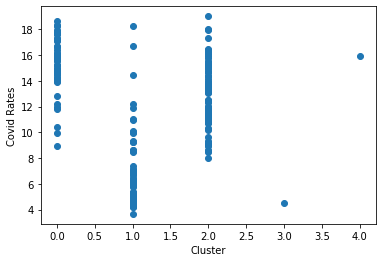

In [58]:
plt.scatter(kmeans.labels_, nyc_df['CovidPercentagePositive'])
plt.xlabel('Cluster')
plt.ylabel('Covid Rates')
plt.show()

We can see different clusters show different covid rate trends. To better have a look at the distributions, we can plot the data in a histogram plot. 

In [59]:
#for cluster 1
group0 = nyc_df[['CovidPercentagePositive']]
group0 = group0[kmeans.labels_==0]
group0.reset_index(inplace = True, drop = True)
h = group0['CovidPercentagePositive']

#for cluster 2
group1 = nyc_df[['CovidPercentagePositive']]
group1 = group1[kmeans.labels_==1]
group1.reset_index(inplace = True, drop = True)
i = group1['CovidPercentagePositive']

#for cluster 3
group2 = nyc_df[['CovidPercentagePositive']]
group2 = group2[kmeans.labels_==2]
group2.reset_index(inplace = True, drop = True)
j = group2['CovidPercentagePositive']

#for cluster 4
group3 = nyc_df[['CovidPercentagePositive']]
group3 = group3[kmeans.labels_==3]
group3.reset_index(inplace = True, drop = True)
k = group3['CovidPercentagePositive']

#for cluster 5
group4 = nyc_df[['CovidPercentagePositive']]
group4 = group4[kmeans.labels_==4]
group4.reset_index(inplace = True, drop = True)
l = group4['CovidPercentagePositive']

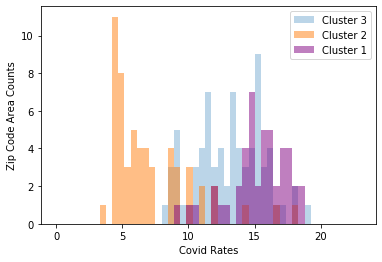

In [75]:
bins = np.linspace(0, 23)

plt.hist(j, bins, alpha=0.3, label='Cluster 3')
plt.hist(i, bins, alpha=0.5, label='Cluster 2')
plt.hist(h, bins, alpha=0.5, label='Cluster 1',color = 'purple')
#plt.hist(k, bins, alpha=0.3, label='Cluster 3', color = 'green')
#plt.hist(l, bins, alpha=0.3, label='Cluster 4', color = 'yellow')
plt.legend(loc='upper right')
plt.xlabel('Covid Rates')
plt.ylabel('Zip Code Area Counts')
plt.show()

Since cluster 4 and 5 has only 1 zipcode area, to simplify the figure, I ignored them in the histogram. 

We can see that in each cluster, covid rates are either mainly high (>10) or low (<10). Even for cluster 4 and 5, with only 1 zip code area in the cluster, they have clear high/low covid rate readings.

Then, let's check the feature venues for low/high covid rates areas:

In [80]:
#Groupd venue matrix by zipcode and sum the total counts
nyc_zipsum = nyc_onehot.groupby('ZipCode').sum().reset_index()
print(nyc_zipsum.shape)
nyc_zipsum.head()

(177, 448)


,ZipCode,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,Airport Tram,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Carpet Store,Casino,Caucasian Restaurant,Cemetery,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Basketball Court,College Cafeteria,College Rec Center,College Residence Hall,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Currency Exchange,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Emergency Room,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Fishing Store,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,National Park,Neighborhood,New American Restaurant,Newsstand,Ni

In [81]:
#categorize covid rates:
covid_cat = []
for index, row in nyc_df.iterrows():
    if row['CovidPercentagePositive']<=10:
        covid_cat = covid_cat +['low']
    else:
        covid_cat = covid_cat +['high']
    
nyc_zipsum.insert(448, "CovidCat", covid_cat, True)
nyc_zipsum.head(2)

,ZipCode,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,Airport Tram,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Carpet Store,Casino,Caucasian Restaurant,Cemetery,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Basketball Court,College Cafeteria,College Rec Center,College Residence Hall,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Currency Exchange,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Emergency Room,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Fishing Store,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,National Park,Neighborhood,New American Restaurant,Newsstand,Ni

Summerize data by covid catogory:

In [82]:
nyc_matrix0 = nyc_zipsum.drop(['ZipCode'], 1)# get the matrix by removing zipcode:
nyc_matrix = nyc_matrix0.groupby('CovidCat').sum().reset_index()#sum the data by covid categories
nyc_matrix.head()

,CovidCat,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,Airport Tram,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Carpet Store,Casino,Caucasian Restaurant,Cemetery,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Basketball Court,College Cafeteria,College Rec Center,College Residence Hall,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Currency Exchange,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Emergency Room,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Fishing Store,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,National Park,Neighborhood,New American Restaurant,Newsstand,N

In [83]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [84]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['CovidCat']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
print(columns)
# create a new dataframe
covidcat_venues_sorted = pd.DataFrame(columns=columns)
covidcat_venues_sorted['CovidCat'] = nyc_matrix['CovidCat']

for ind in np.arange(nyc_matrix.shape[0]):
    covidcat_venues_sorted.iloc[ind, 1:] = return_most_common_venues(nyc_matrix.iloc[ind, :], num_top_venues)

covidcat_venues_sorted.head()

['CovidCat', '1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue', '4th Most Common Venue', '5th Most Common Venue', '6th Most Common Venue', '7th Most Common Venue', '8th Most Common Venue', '9th Most Common Venue', '10th Most Common Venue']


,CovidCat,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,high,Pizza Place,Donut Shop,Deli / Bodega,Pharmacy,Chinese Restaurant,Sandwich Place,Bank,Bakery,Grocery Store,Italian Restaurant
1,low,Coffee Shop,Bar,Italian Restaurant,Pizza Place,Bakery,Café,American Restaurant,Mexican Restaurant,Park,Cocktail Bar


In [85]:
#to plot the word cloud:
nyc_matrixT = nyc_matrix.T
new_header = nyc_matrixT.iloc[0] #grab the first row for the header
nyc_matrixT = nyc_matrixT[1:] #take the data less the header row
nyc_matrixT.columns = new_header #set the header row as the df header
nyc_matrixT.head(2)

CovidCat,high,low
Accessories Store,4,4
Adult Boutique,0,1


In [101]:
#for high covid rate areas:
total_venue_high = nyc_matrixT['high'].sum()
max_words = 90
word_string_high = ''
for venue in nyc_matrixT.index.values:
    # check if country's name is a single-word name
    if len(venue.split(' ')) == 1:
        repeat_num_times = int(nyc_matrixT.loc[venue, 'high']/float(total_venue_high)*max_words)
        word_string_high = word_string_high + ((venue + ' ') * repeat_num_times)
    else:
        short_name = venue.replace(" ", "") #Remove the space between the words
        #short_name
        repeat_num_times = int(nyc_matrixT.loc[venue, 'high']/float(total_venue_high)*max_words)
        word_string_high = word_string_high + ((short_name + ' ') * repeat_num_times)                             

word_string_high

'Bakery Bakery Bank Bank Bar BusStation CaribbeanRestaurant ChineseRestaurant ChineseRestaurant CoffeeShop Deli/Bodega Deli/Bodega Diner DiscountStore DonutShop DonutShop FastFoodRestaurant FriedChickenJoint GroceryStore GroceryStore IceCreamShop ItalianRestaurant ItalianRestaurant MexicanRestaurant MobilePhoneShop Park Pharmacy Pharmacy PizzaPlace PizzaPlace PizzaPlace PizzaPlace PizzaPlace SandwichPlace SandwichPlace Supermarket '

In [ ]:
# install wordcloud
! conda install -c conda-forge wordcloud
# import package and its set of stopwords
from wordcloud import WordCloud, STOPWORDS 

In [ ]:
covid_high = open('covid_high.txt', 'r').read()

# create the word cloud
wordcloud = WordCloud(background_color='white',collocations=False).generate(covid_high)

# display the cloud
fig = plt.figure()
fig.set_figwidth(14)
fig.set_figheight(18)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Unfortunately, the jupyter notebook froze up everytime when I tried to install wordcloud package. So I finished this part in the Visualization Tools of the course lab session. Below is the word cloud for the high covid rate areas:

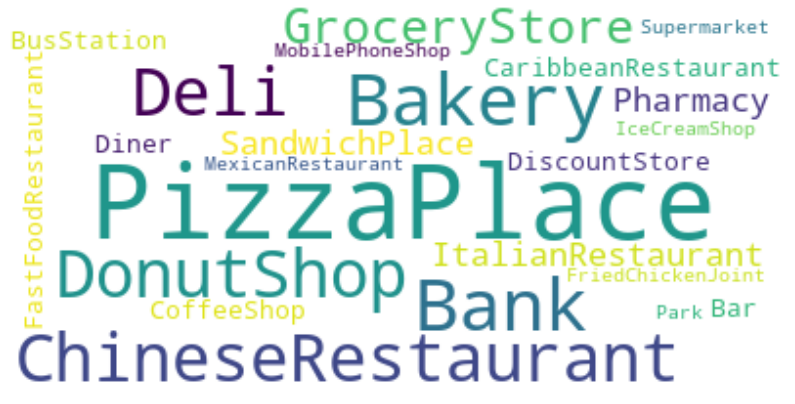

Using the same method, we can generate a word cloud for the low covid rate areas as well:

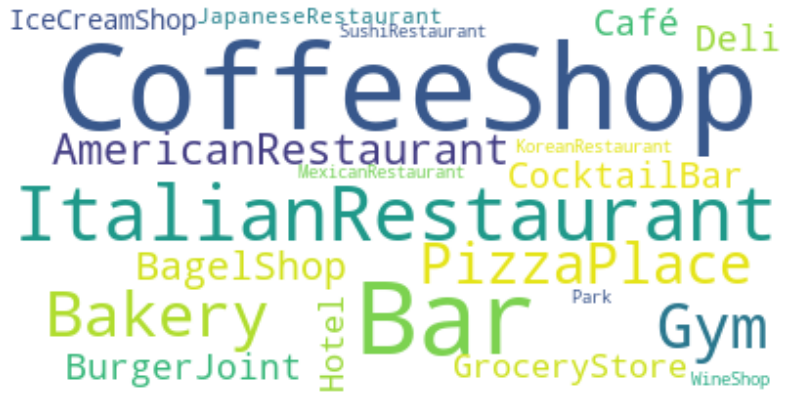

Venue types seem to be different for low covid rate areas and high covid rate areas.

## Methodology

1. Plot covid rates on map with Folium and choropleth.

2. After importing data from different data sets, conduct some exploratory data analysis to see possible relationships between all types of factors and covid rates variation.

3. Use k-means method to cluster zipcode areas based on venue types and check the covid rates distributions with histogram for each cluster.

4. Use word cloud to show the feature venues of different covid rate areas.



## Results and Discussion

From the exploratory data analysis, the data implied that the **population density** has no direct relationship with covid rates variation. However, this value can only reflect people density based on residential area. Business area and transportation hubs can also have high people density every day, but without residential buildings, the registered population could be very low.

**Percentage of Senior** has no contribution to covid rates, while **youth ratio** is greatly correlated with covid rates. I think the main difference between the two groups is their social activity modes. Young people have a higher possibility to go to a bar, a restaurant or a movie theater with a group of friends, while senior people are most likely to have relative quiet activities with their families in a relative private spot. More vulnerable to virus does not make senior people more easily to get the disease, but just after getting the virus, their possibility to have severe symptoms is higher. Also, young people, as students, also need to go to school. This situation also put them under a higher risk to get infected.

Surprisingly, higher **density of the restaurant** in an area gives a lower covid rate. Maybe people don't usually eat in their neighborhood, or there could be other explanations. To dig deeper into the venue information, I clustered the zip code areas based on their venue types and found that areas in the same cluster show the similar covid rates. This is not surprising to me, because similar types venue combination implies similar type of activities in the area. In the last step, word cloud was used to present the most featured venues for low covid rate areas and high covid rate areas. This doesn't necessarily mean venues types in low covid rate plot are safer than others. It is just to see the features of the areas.


## Conclusion

This study briefly analyzed some possible covid influence factors in the zip code areas in New York City. Possible explanations were given for each individual observation. 

Higher or lower covid rate in an area does not mean how good or bad the area is. The rate is just to send a reminder for people to still stay alert and stay safe. 